# Predicción-Evapotranspiracion

https://github.com/pabsaura/MachineLearning-Evapotranspiracion

Author: Pablo Saura 


# Entender el caso de negocio

** En este caso el objetivo es ser capaz de dar una prescripcion de riego adecuada a una zona geografica concreta. Esta información es muy útil para los agricultores, saber la cantidad exacta de agua que deben usar repercute en menos gastos por riego y maximización de la recolección.**

**En concreto el principal foco de este trabajo es el de obtener valores futuros para el valor de la [evapotranspiración](https://es.wikipedia.org/wiki/Evapotranspiración), la cual se define como, la pérdida de humedad de una superficie por evaporación directa junto con la pérdida de agua por transpiración de la vegetación. Este valor es importante para conocer las necesidades hídricas de las plantas y poder actuar de forma óptima.**

**Para ello vamos a utilizar variables climáticas obtenidas de estaciones meteorológicas y con ellas crear un programa capaz de predecir el valor deseado.**



# Predicción Evapotraspiración 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from math import sqrt
from datetime import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
def standarizar_df(df_combinado):
    """
    """
    from sklearn import preprocessing
    std_scale = preprocessing.StandardScaler().fit(df_combinado)
    df_std = std_scale.transform(df_combinado)
    return df_std


### Entender el Dato

In [2]:
#data = pd.read_csv('losnavalmoralesFull.csv',sep=';',encoding='utf_16_le' ) #Version que se actualiza cada dia. 
data = pd.read_csv('losnavalmorales.csv',sep=';',encoding='utf_16_le' )  #Version con datos sin tratar, comentar el de arriba
data.tail(5)

,IdProvincia,IdEstacion,Fecha,Año,Dia,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Radiación (MJ/m2),Precipitación (mm),PePMon,EtPMon
6254,45,4,12/03/2018,2018,71,"8,07","11,38","6,01","73,1","89,7","53,64","13,97","0,2",0,"2,29"
6255,45,4,13/03/2018,2018,72,"9,74","14,1","5,67","82,5","98,6","65,09","12,82","1,37",0,"1,86"
6256,45,4,14/03/2018,2018,73,"9,67","12,85","5,6","87,6","96,4","79,2","5,98","16,86","10,28","1,27"
6257,45,4,15/03/2018,2018,74,"7,2","10,91","4,67","80,3","95,2","60,04","13,09","1,47",0,"1,94"
6258,45,4,16/03/2018,2018,75,"5,66","9,46","3,22","78,7","91,6","54,86","13,21","0,69",0,"1,93"


 Este es el dataset que se obtiene al descargar directamente y sin tratar,  por ello vamos a realizar la limpieza y preparación de los datos.

In [3]:
#data['Fecha']= pd.to_datetime(data.Fecha, format='%Y/%m/%d') #Descomentar para tratar la fecha del 'losnavalmoralesFull'
data =data.drop(["IdProvincia","IdEstacion","Año","Dia"],axis=1); # Version con datos sin tratar, descomentar.
data['Fecha']= pd.to_datetime(data.Fecha, format='%d/%m/%Y')
cols = data.columns[data.dtypes.eq('object')]
for i in cols:
    data[i] = pd.to_numeric(data[i].str.replace(',', '.'))
data.dtypes    

Fecha                 datetime64[ns]
Temp Media (ºC)              float64
Temp Max (ºC)                float64
Temp Mínima (ºC)             float64
Humedad Media (%)            float64
Humedad Max (%)              float64
Humedad Min (%)              float64
Radiación (MJ/m2)            float64
Precipitación (mm)           float64
PePMon                       float64
EtPMon                       float64
dtype: object

Quitamos los datos que no nos aportan información como son "IdProvincia","IdEstacion" y "Año","Dia", ya que la fecha la tenemos representada en el valor con mismo nombre. Transformamos los atributos al tipo que corresponde, la fecha a tipo ***datetime*** y los demas valores a ***Float***, ya que al leerlos con ***pd.read_csv*** los toma como strings.

En las siguintes celdas imprimimos si hay valores nulos, los completamos con el valor anterior y cambiamos el indice del ***dataframe*** para que sean las fechas.

In [4]:
print(data.shape)
data.isnull().sum() # Buscamos si hay valores nulos

(6259, 11)


Fecha                  0
Temp Media (ºC)       17
Temp Max (ºC)         27
Temp Mínima (ºC)      24
Humedad Media (%)     31
Humedad Max (%)       61
Humedad Min (%)       59
Radiación (MJ/m2)     15
Precipitación (mm)    21
PePMon                69
EtPMon                69
dtype: int64

In [5]:
data = data.fillna(method='ffill') # En el caso en que haya valores nulos los rellenamos con el valor anterior.
data.isnull().sum()

Fecha                 0
Temp Media (ºC)       0
Temp Max (ºC)         0
Temp Mínima (ºC)      0
Humedad Media (%)     0
Humedad Max (%)       0
Humedad Min (%)       0
Radiación (MJ/m2)     0
Precipitación (mm)    0
PePMon                0
EtPMon                0
dtype: int64

In [6]:
data = data.set_index('Fecha'); # Cambiar el indice por las fechas.

In [7]:
print(min(data["EtPMon"]))
print(max(data["EtPMon"]))
print(data["EtPMon"].values.mean())

0.0
10.13
3.73966927624


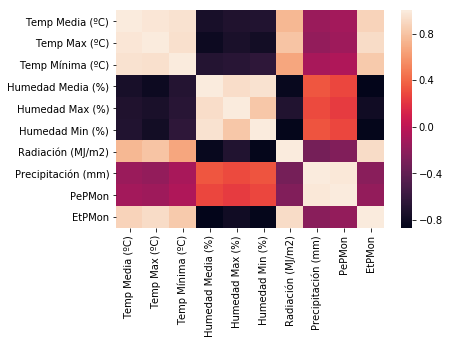

In [8]:

corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

Mediante esta matriz de correlación podemos ver como se afectan las variables unas con otras, esta claro que variables relacionadas entre si como temperaturas y humedades cuentan con una gran correlación entre si, de igual manera temperaturas y humedades enfrentadas unas a otras vemos que tiene una correlacion pero a la inversa. Como también podiamos pensar la precipitación y la humedad tienen una alta correlación.

Seguimos con una gráfica de los valores que toma en la muestra la evapotranspiración, vemos que la muestra esta un poco desbalanceada.

C:\Users\Pablo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


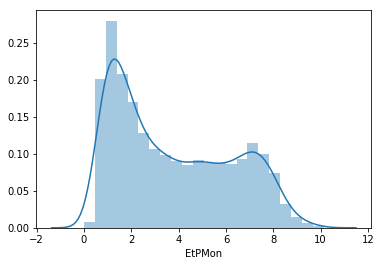

In [9]:
sns.distplot(data["EtPMon"]);

C:\Users\Pablo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


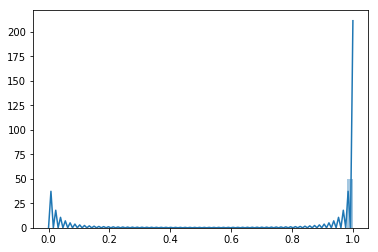

In [10]:
# Datos de la evapotranspiracion normalizados
normalized = data["EtPMon"]
a =preprocessing.normalize(normalized.values.reshape(-1,1))
sns.distplot(a);

Vemos que normalizando los datos se nos quedan los valores demasiado en los extremos. Por tanto no es una buena aproximación.

C:\Users\Pablo\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


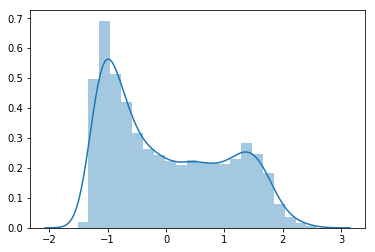

In [11]:
#Datos de la evapotranspiracion standarizados
normalized = data["EtPMon"]
a =standarizar_df(normalized.values.reshape(-1,1))
sns.distplot(a);

En cambio al estandarizar ponemos la media de los valores en 0(media=3,73), la proporción se mantiene a la original.

Podemos poner graficamente como varia la evapotranspiración en fucnion de otras variables para entender de mejor manera los datos:

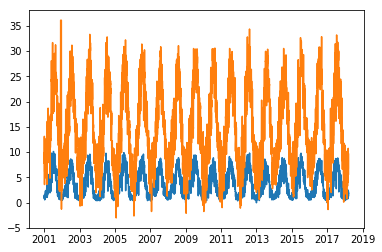

In [12]:
import matplotlib.pyplot as plt
plt.plot(data['EtPMon'])
plt.plot(data['Temp Media (ºC)'])
plt.ylabel('')
plt.show()

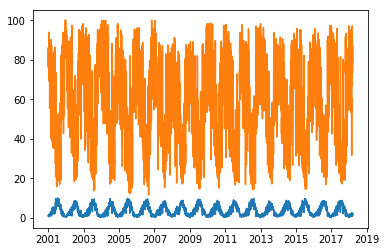

In [13]:
import matplotlib.pyplot as plt
plt.plot(data['EtPMon'])
plt.plot(data['Humedad Media (%)'])
plt.ylabel('')
plt.show()

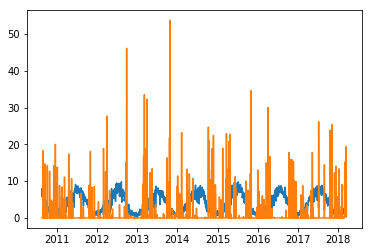

In [14]:
import matplotlib.pyplot as plt
plt.plot(data['EtPMon'][3500:])
plt.plot(data['Precipitación (mm)'][3500:])
plt.ylabel('')
plt.show()

## Separación training-test

Mediante la función de la librería scikit-learn podemos crear las muestras para entrenamiento y test que despues pasaremos a los modelos

In [15]:
labels=data["EtPMon"]
dataAll=data.copy()
data =data.drop(["EtPMon"],axis=1);
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,test_size=0.20,random_state=20)

In [16]:
data.head(5)

,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Radiación (MJ/m2),Precipitación (mm),PePMon
Fecha,,,,,,,,,
2001-01-01,9.36,11.89,7.64,86.0,95.9,77.70,3.77,6.8,3.26
2001-01-02,7.78,10.22,6.11,78.8,92.8,62.15,6.92,7.2,3.56
2001-01-03,7.90,9.70,6.18,82.3,90.3,72.50,3.77,3.4,0.52
2001-01-04,10.25,12.36,8.69,76.3,88.5,63.95,6.32,0.0,0.00
2001-01-05,13.12,15.54,8.83,85.7,94.9,77.90,3.75,4.6,1.52


## Primer modelo: Regresión Lineal

El primer modelo que vamos a crear es el de regresión lineal

In [17]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train);

In [18]:
prediction = regr.predict(X_test)

In [19]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [ 0.02351795  0.02944625  0.07065135 -0.02510693  0.0007251   0.0025977
  0.14838745  0.19778249 -0.28731524]


In [20]:
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(Y_test, prediction)))

Root Mean squared error: 0.55


In [21]:
print('Variance score: %.2f' % r2_score(Y_test, prediction))

Variance score: 0.95


In [22]:
aux=Y_test[:10]
Y_test[:10]

Fecha
2017-01-09    1.32
2006-09-11    5.35
2010-07-11    8.19
2001-12-06    0.56
2010-12-17    0.97
2002-03-01    1.98
2016-10-07    4.14
2012-11-02    1.88
2014-09-30    3.32
2001-09-12    5.31
Name: EtPMon, dtype: float64

In [23]:
prediction[:10]

array([ 1.91797581,  5.62152796,  7.96945251,  1.54844811,  1.31587586,
        2.07937472,  5.34859495,  2.33213047,  4.25268386,  5.75878186])

In [24]:
aux=aux.reset_index()
aux= aux.drop(['Fecha'],axis=1)


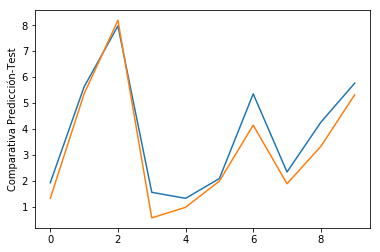

In [25]:
plt.plot(prediction[:10])
plt.plot(aux)
plt.ylabel('Comparativa Predicción-Test')
plt.show()

Como vemos obtenemos un RMSE de 0.55 y una varianza del 95%, aunque no son unos datos magnificos nos sirven como primera aproximación para la predicción de los valores. 
Se han puesto tambien las 10 últimas predicciones para comparar frente al test y ver cuanto es el error.

## Estandarizando los datos

In [26]:
std_X_train = standarizar_df(X_train)
std_X_test = standarizar_df(X_test)

In [27]:
lm = linear_model.LinearRegression()
lm.fit(std_X_train, Y_train)
predicted_values = lm.predict(std_X_test)


In [28]:
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(Y_test, predicted_values)))

Root Mean squared error: 0.56


In [29]:
print('Variance score: %.2f' % r2_score(Y_test, prediction))

Variance score: 0.95


En este ejemplo se usa una función para la estandarización de los datos y vemos que no difiere casi del resultado anterior.

## CrossValidation

In [30]:
from sklearn.model_selection import cross_val_score, cross_val_predict
lm2 = linear_model.LinearRegression()
scores = cross_val_score(lm2, data, labels, cv=100,scoring='neg_mean_squared_error')
sqrt(- scores.mean())

0.6267493653747079

En este ejemplo utilizamos la crossvalidación como método evaluación.

## Aumentando la dimensionalidad

Para este caso se prueba a aumentar las variables teniendo en cuenta hata que días anteriores, y ver si de esra manera se pyuede reducir el error obtenido

In [31]:
data2=data.copy()

In [32]:
for i in range(6):
    data2['Temp Media (ºC)'+str(-i)] = data['Temp Media (ºC)'][i:]
    data2['Temp Max (ºC)'+str(-i)] = data['Temp Max (ºC)'][i:]
    data2['Temp Mínima (ºC)'+str(-i)] = data['Temp Mínima (ºC)'][i:]
    data2['Humedad Media (%)'+str(-i)] = data['Humedad Media (%)'][i:]
    data2['Humedad Max (%)'+str(-i)] = data['Humedad Max (%)'][i:]
    data2['Humedad Min (%)'+str(-i)] = data['Humedad Min (%)'][i:]
    data2['Radiación (MJ/m2)'+str(-i)] = data['Radiación (MJ/m2)'][i:]
    data2['Precipitación (mm)'+str(-i)] = data['Precipitación (mm)'][i:]
    data2['PePMon'+str(-i)] = data['PePMon'][i:]                                        

In [33]:
data2.head(10)

,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Radiación (MJ/m2),Precipitación (mm),PePMon,Temp Media (ºC)0,...,PePMon-4,Temp Media (ºC)-5,Temp Max (ºC)-5,Temp Mínima (ºC)-5,Humedad Media (%)-5,Humedad Max (%)-5,Humedad Min (%)-5,Radiación (MJ/m2)-5,Precipitación (mm)-5,PePMon-5
Fecha,,,,,,,,,,,,,,,,,,,,,
2001-01-01,9.36,11.89,7.64,86.0,95.9,77.70,3.77,6.8,3.26,9.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,7.78,10.22,6.11,78.8,92.8,62.15,6.92,7.2,3.56,7.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,7.90,9.70,6.18,82.3,90.3,72.50,3.77,3.4,0.52,7.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,10.25,12.36,8.69,76.3,88.5,63.95,6.32,0.0,0.00,10.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,13.12,15.54,8.83,85.7,94.9,77.90,3.75,4.6,1.52,13.12,...,1.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-06,6.87,9.43,4.13,83.1,96.6,65.48,6.79,14.8,8.92,6.87,...,8.92,6.87,9.43,4.13,83.1,96.6,65.48,6.79,14.8,8.92
2001-01-07,4.17,7.91,1.33,76.5,93.7,47.43,8.38,0.0,0.00,4.17,...,0.00,4.17,7.91,1.33,76.5,93.7,47.43,8.38,0.0,0.00
2001-01-08,3.59,7.51,0.61,75.6,87.5,53.91,9.08,0.0,0.00,3.59,...,0.00,3.59,7.51,0.61,75.6,87.5,53.91,9.08,0.0,0.00
2001-01-09,5.63,9.04,1.46,79.8,96.6,52.19,1.76,0.8,0.00,5.63,...,0.00,5.63,9.04,1.46,79.8,96.6,52.19,1.76,0.8,0.00


In [34]:
data2 = data.drop(data.index[:5])
labels2 = labels.drop(labels.index[:5])


In [35]:
X2_train,X2_test,Y2_train,Y2_test = train_test_split(data2,labels2,test_size=0.20,random_state=20)

In [36]:
regr = linear_model.LinearRegression()
regr.fit(X2_train, Y2_train)
prediction = regr.predict(X2_test)
print('Coefficients: \n', regr.coef_)
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(Y2_test, prediction)))
print('Variance score: %.2f' % r2_score(Y2_test, prediction))

Coefficients: 
 [ 0.01838224  0.0304453   0.0756795  -0.02503331  0.00102455  0.00254962
  0.14829209  0.1775675  -0.25069667]
Root Mean squared error: 0.56
Variance score: 0.95


In [37]:
print(Y2_test[:10]); print(prediction[:10])

Fecha
2013-04-11    2.98
2018-02-03    1.47
2014-09-05    6.12
2001-11-15    1.41
2013-12-02    1.64
2011-07-17    8.02
2014-11-10    1.29
2016-03-20    1.19
2009-09-10    5.38
2006-11-05    0.44
Name: EtPMon, dtype: float64
[ 2.92913021  1.73938684  6.47891945  0.47960108  1.9061955   7.2855427
  1.97842847  1.18099736  5.93509065  0.62604587]


In [38]:
aux=Y2_test[:10]

In [39]:
aux=aux.reset_index()
aux= aux.drop(['Fecha'],axis=1)

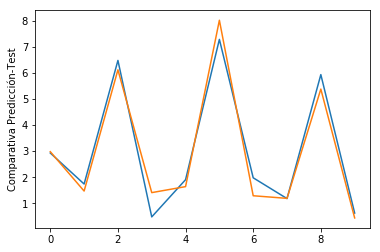

In [40]:
plt.plot(prediction[:10])
plt.plot(aux)
plt.ylabel('Comparativa Predicción-Test')
plt.show()

## Árboles de decisión

Otro modelo que podemos aplicar son los árboles de decisión y en concreto los de tipo regressor. Esperando conseguir una disminución del error frente a la regresión lineal. Como ya separamos los datos para las regresiones lineales vamos a ejecutar los mismos ejemplos pero con árboles ahora.
En los códigos se han incluido tanto los decision tree como los metodos ensemble RandomForest, comentando uno y descomentando el otro se puede ver la diferencia en la ejecucíon entre uno y otro.

#### Alta dimensionalidad

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#regressor = DecisionTreeRegressor(random_state=0)
regressor = RandomForestRegressor(criterion='mse')
regressor.fit(X2_train,Y2_train)
modelPred = regressor.predict(X2_test)
meanSquaredError=mean_squared_error(Y2_test, modelPred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 0.229972759392
RMSE: 0.479554751193736


#### Datos sin tratar

In [42]:
#regressor = DecisionTreeRegressor(random_state=0)
regressor = RandomForestRegressor(criterion='mse')
regressor.fit(X_train,Y_train)
modelPred = regressor.predict(X_test)
meanSquaredError=mean_squared_error(Y_test, modelPred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 0.215111788339
RMSE: 0.4638014535754046


#### Estandarizando

In [43]:
#regressor = DecisionTreeRegressor(random_state=0)
regressor = RandomForestRegressor(criterion='mse')
regressor.fit(std_X_train,Y_train)
modelPred = regressor.predict(std_X_test)
meanSquaredError=mean_squared_error(Y_test, modelPred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

MSE: 0.225895988818
RMSE: 0.4752851657877525


#### Cross-validation

In [44]:
regressor = RandomForestRegressor(criterion='mse')
scores = cross_val_score(regressor, data, labels, cv=10,scoring='neg_mean_squared_error')
print("RMSE:", sqrt(-scores.mean()))

RMSE: 0.47816414352189973


## Reduciendo a variables solo de predicción(las que podemos encontrar en AEMET)

Como se trata de una predicción y la base de datos es a posteriori, vamos a realizar otra en la que solo tengamos los datos que se pueden obtener a futuro, para eso realizaremos la obtención de variables sobre la página de la AEMET.

Datos que puedo obtener de previsión en AEMET:
- Probabilidad de precipitación.
- Temperatura max,min.
- Humedad relativa max,min.
- Precipitacion



### Conviertiendo la precipitacion a booleano

Como no podemos saber cuanta precipitacion de lluvia va a caer con certeza para un día en el futuro, vamos a modelar nuestros datos como un booleano el cual denotará si llovió ese día o no lo hizo.

In [45]:

elements = data['Precipitación (mm)'].values
elements_ok = [1 if element > 0 else 0 for element in elements]
data['Precipitación (mm)'] = elements_ok


Quitamos la radiación y la precipitación efectiva ya que son datos que no podemos conocer.

In [46]:

data_red = data.drop(['Radiación (MJ/m2)','PePMon'],axis=1);
X_train,X_test,Y_train,Y_test = train_test_split(data_red,labels,test_size=0.20)

In [47]:
data_red.head(5)

,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Precipitación (mm)
Fecha,,,,,,,
2001-01-01,9.36,11.89,7.64,86.0,95.9,77.70,1
2001-01-02,7.78,10.22,6.11,78.8,92.8,62.15,1
2001-01-03,7.90,9.70,6.18,82.3,90.3,72.50,1
2001-01-04,10.25,12.36,8.69,76.3,88.5,63.95,0
2001-01-05,13.12,15.54,8.83,85.7,94.9,77.90,1


Este sería el aspecto de nuestra nueva base de datos. Aplicamos los mismos modelos que antes sabiendo que el error será más grande al tener menos representatividad.

### Regresión lineal

In [48]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
prediction = regr.predict(X_test)
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(Y_test, prediction)))
print('Variance score: %.2f' % r2_score(Y_test, prediction))

Root Mean squared error: 0.80
Variance score: 0.90


### Árboles de decisión

In [49]:
#regressor = DecisionTreeRegressor(random_state=0)
regressor = RandomForestRegressor(criterion='mse')
regressor.fit(X_train,Y_train)
modelPred = regressor.predict(X_test)
meanSquaredError=mean_squared_error(Y_test, modelPred)
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)
print('Variance score: %.2f' % r2_score(Y_test, modelPred))

MSE: 0.561811035144
RMSE: 0.7495405493659232
Variance score: 0.91


## Prediciendo el valor de Mañana

El objetivo al final es predecir el valor de evapotranspiración para el día siguiente, para ello hemos creado los modelos de aprendizaje. Por ello debemos acceder a la previsión meteorológica para el día que queremos predecir y pasarselo al modelo para que nos de el valor.

Esta obtención se ha realizado mediante scrapping de la web de la AEMET.





### Web scrapping Aemet

In [50]:
from lxml import etree
doc = etree.parse('http://www.aemet.es/xml/municipios/localidad_45112.xml')
raiz=doc.getroot()
prediccion = raiz[4]
#dia = prediccion[1] # Para coger la prevision de mañana.
dia = prediccion[0] # Para coger la prevision de hoy.
fecha=dia.get('fecha')
temperatura=dia.find("temperatura")
probprecipitacion=dia.find("prob_precipitacion")
temperaturaMax=float(temperatura.find("maxima").text)
temperaturaMin=float(temperatura.find("minima").text)
humedad=dia.find("humedad_relativa")
humedadMax=float(humedad.find("maxima").text)
humedadMin=float(humedad.find("minima").text)
humedadMed=((humedadMax)+(humedadMin))/2
temperaturaMed=((temperaturaMax)+(temperaturaMin))/2
precipitacion= 0 if probprecipitacion.text == None else int(probprecipitacion.text)
precipitaciondummy = 1 if precipitacion > 60 else 0
print("Prevision: ",fecha)
print("Temperatura Max:",temperaturaMax)
print("Temperatura Min:",temperaturaMin)
print("Temperatura Med:",temperaturaMed)
print("Humedad Max:",humedadMax)
print("Humedad Min:",humedadMin)
print("Humedad Med:",humedadMed)
print("Precipitacion:",precipitaciondummy)


Prevision:  2018-04-11
Temperatura Max: 13.0
Temperatura Min: 2.0
Temperatura Med: 7.5
Humedad Max: 95.0
Humedad Min: 40.0
Humedad Med: 67.5
Precipitacion: 0


Guardamos los valores en una variable que le pasaremos al modelo.

In [51]:
d = pd.DataFrame.from_items([(fecha,[temperaturaMed,temperaturaMax,temperaturaMin,humedadMed,humedadMax,humedadMin,precipitaciondummy])],orient='index', columns=(['Temp Media (ºC)','Temp Max (ºC)','Temp Minima (ºC)','Humedad Media (%)','Humedad Max (%)','Humedad Min (%)','Precipitación (mm)']))
d.dtypes
d

,Temp Media (ºC),Temp Max (ºC),Temp Minima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Precipitación (mm)
2018-04-11,7.5,13.0,2.0,67.5,95.0,40.0,0


In [52]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
prediction = regr.predict(d)
print("Prediccion de la evapotranspiracion de referencia para el dia",fecha,":",prediction[0])

Prediccion de la evapotranspiracion de referencia para el dia 2018-04-11 : 2.31480535624


### Para no saturar mucho este notebook, se ha realizado una última prueba teniendo en cuenta la evapotranspiración del día anterior. 
### Esta prueba se ha realizado en el notebook ***Prediccion-EvapotranspiracionAnterior*** el cual se encuentra en la misma carpeta. Link to [Notebook](Prediccion-EvapotranspiracionAnterior.ipynb)

### De forma anecdótica también intente seguir un tutorial sobre Time Series en bases de datos multivariable sin mucha fortuna. [MultiVariate time series forecasting](MultiVariate time series forecasting.ipynb)

# Bonus Track

Esta sección nos va a permitir la obtención periódica de los datos de las estaciones meteorológicas con previsión de ser ejecutado en un servidor cada día para la realización de la previsión con los datos actualizados.

### Descargar automatica diaria del valor correcto de Evapotraspiracion con Selenium

In [53]:
from selenium.webdriver.firefox.firefox_profile import FirefoxProfile
profile = FirefoxProfile ()
profile.set_preference("browser.download.folderList",2)
profile.set_preference("browser.download.manager.showWhenStarting",False)
profile.set_preference("browser.download.dir","c:\\Users\Pablo\Desktop\EntregaAnalisis-PabloSaura")
profile.set_preference("browser.helperApps.neverAsk.saveToDisk","application/zip")


In [54]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import time
driver = webdriver.Firefox(firefox_profile=profile) # Se crea la instancia de Firefox WebDriver
driver.get("http://eportal.mapama.gob.es/websiar/SeleccionParametrosMap.aspx?dst=1")
driver.implicitly_wait(5)
driver.maximize_window()
elem = Select(driver.find_element_by_name("ctl00$ContentPlaceHolder1$DropDownListCCAA"))
elem.select_by_visible_text("Castilla-La Mancha")
time.sleep(2)

elem = Select(driver.find_element_by_name("ctl00$ContentPlaceHolder1$DropDownListProvincia"))
elem.select_by_visible_text("Toledo")

elem = Select(driver.find_element_by_name("ctl00$ContentPlaceHolder1$DropDownListEstacion"))
elem.select_by_visible_text("Los Navalmorales")
time.sleep(1)
elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$ButtonAgregar")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$CheckBoxVViento")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$CheckBoxListParametros$CheckBoxListParametros_2")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$CheckBoxListParametros$CheckBoxListParametros_8")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$CheckBoxListParametros$CheckBoxListParametros_4")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$CheckBoxListParametros$CheckBoxListParametros_10")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$CheckBoxDViento")
elem.click()

elem = driver.find_element_by_name("ctl00$ContentPlaceHolder1$btnConsultar")
elem.click()

driver.switch_to.window(driver.window_handles[1])
time.sleep(1)
content = driver.find_element_by_xpath('//*[@id="ContentPlaceHolder1_ExportarCSV"]')
content.click()                               
time.sleep(3) #Tiempo prudencial para que descarge

driver.quit() # Si usamos “quit” cerramos todo el navegador, no solo la página actual

### Descomprimiendo el archivo guardado y uniendolo al dataframe

In [55]:
import zipfile, os
with zipfile.ZipFile("InformeDatos.zip","r") as zip_ref:
    zip_ref.extractall(".")
    
path = '.'
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)) and 'TO04' in i:
        file=i
os.rename(file, 'losnavalmoralesUpdate.csv')
os.remove("InformeDatos.zip") 

In [56]:
dataUpdate = pd.read_csv('losnavalmoralesUpdate.csv',sep=';',encoding='utf_16_le' )
dataUpdate

,IdProvincia,IdEstacion,Fecha,Año,Dia,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Radiación (MJ/m2),Precipitación (mm),PePMon,EtPMon
0,45,4,04/04/2018,2018,94,"9,37","13,64","6,07","78,9","95,4","60,64","16,46","5,59","2,32","2,46"
1,45,4,05/04/2018,2018,95,"11,6","16,75","5,47","68,74","86,7","52,96","22,51",0,0,"3,2"
2,45,4,06/04/2018,2018,96,"12,49","17,95","7,67",70,"87,3","51,29","10,96","0,98",0,"2,39"
3,45,4,07/04/2018,2018,97,"7,59","12,17","5,61","87,8","97,9","61,31","10,56","7,45","3,76","1,76"
4,45,4,08/04/2018,2018,98,"8,48","12,84","5,41","80,8","97,3","55,71","18,2","0,59",0,"2,56"
5,45,4,09/04/2018,2018,99,"4,78","6,27","2,55","85,8","95,5","76,3","9,53","1,47",0,"1,26"
6,45,4,10/04/2018,2018,100,"5,32","8,74","3,02","88,9","95,1","75,7","5,18","8,82","4,77","1,15"


In [57]:
dataUpdate['Fecha']= pd.to_datetime(dataUpdate.Fecha, format='%d/%m/%Y')
dataUpdate =dataUpdate.drop(["IdProvincia","IdEstacion","Año","Dia"],axis=1);
cols = dataUpdate.columns[dataUpdate.dtypes.eq('object')]
for i in cols:
    dataUpdate[i] = pd.to_numeric(dataUpdate[i].str.replace(',', '.'))

In [58]:
dataUpdate = dataUpdate.set_index('Fecha');
dataUpdate = dataUpdate.fillna(method='ffill')
dataUpdate.dtypes

Temp Media (ºC)       float64
Temp Max (ºC)         float64
Temp Mínima (ºC)      float64
Humedad Media (%)     float64
Humedad Max (%)       float64
Humedad Min (%)       float64
Radiación (MJ/m2)     float64
Precipitación (mm)    float64
PePMon                float64
EtPMon                float64
dtype: object

In [59]:

dataFull=pd.concat([dataAll, dataUpdate])
dataFull=dataFull.drop_duplicates(keep='first')
dataFull.tail(20)

,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Humedad Max (%),Humedad Min (%),Radiación (MJ/m2),Precipitación (mm),PePMon,EtPMon
Fecha,,,,,,,,,,
2018-03-04,8.29,12.64,5.34,80.60,95.4,50.51,12.84,7.64,3.90,2.13
2018-03-05,5.86,8.33,3.54,86.50,97.2,78.50,7.58,8.33,4.41,1.08
2018-03-06,6.05,8.79,3.95,80.80,90.6,69.72,9.60,1.37,0.00,1.47
2018-03-07,6.16,11.64,1.35,67.36,89.5,34.25,15.89,0.98,0.00,2.10
2018-03-08,6.83,9.92,3.41,97.10,98.9,90.80,5.53,3.63,0.71,0.81
2018-03-09,10.75,12.66,8.93,88.30,98.5,81.20,3.97,2.94,0.12,1.03
2018-03-10,10.46,12.79,6.73,82.90,98.1,65.70,6.80,19.40,11.92,1.63
2018-03-11,6.72,9.26,5.59,82.90,93.0,70.60,11.47,3.53,0.63,1.59
2018-03-12,8.07,11.38,6.01,73.10,89.7,53.64,13.97,0.20,0.00,2.29


In [60]:
dataFull.to_csv('losnavalmoralesFull.csv',sep=';',encoding='utf_16_le')
os.remove("losnavalmoralesUpdate.csv") 

Por último se modifica el archivo de donde se obtienen los datos. Se debe descomentar la linea donde se cargan los datos ***losnavalmoralesFull*** para poder realizar la actualización automática.